In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import f1_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Normalization**

In [2]:
def min_max_normalize(image_data, label = 0):
    
    if label == 1:
        image_data_reshaped = image_data
    else:
        image_data_reshaped = image_data.reshape(-1, 4)

    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Fit the scaler to your data and transform it
    normalized_image_data = scaler.fit_transform(image_data_reshaped)

    # Reshape it back to (256, 256, 4) if needed
    if label != 1:
        normalized_image_data = normalized_image_data.reshape(256, 256, 4)
    
    return normalized_image_data


In [3]:
def normalize_all_images(root, dataset, label = 0):
    
    root = root
    subdirs = os.listdir(root)
    
    if label == 1:
        files = sorted(os.listdir(root))
        for file in files:
            path = os.path.join(root,file)
            image = cv2.imread(path,cv2.IMREAD_UNCHANGED)
            image_data = min_max_normalize(image,label)
            #image_data = image
            dataset.append(image_data)
        return dataset

    for subdir in subdirs:
        subdir_path = os.path.join(root,subdir)
        image_files = sorted(os.listdir(subdir_path))
        
        for image_file in image_files:
            path = os.path.join(root,subdir,image_file)
            image_file = cv2.imread(path,cv2.IMREAD_UNCHANGED)
            image_data = min_max_normalize(image_file,label)
            #image_data = image_file
            dataset.append(image_data)
            
    return dataset
    

In [4]:
train_image_root = '/kaggle/input/spacenus-bands-combined-images-and-labels/spacenus_combined_images_and_labels/train'
train_image_dataset = []

test_image_root = '/kaggle/input/spacenus-bands-combined-images-and-labels/spacenus_combined_images_and_labels/test'
test_image_dataset = []

label_image_root = '/kaggle/input/spacenus-bands-combined-images-and-labels/spacenus_combined_images_and_labels/label'
label_image_dataset = []

train_image_dataset = normalize_all_images(train_image_root, train_image_dataset)
print("Number of images in train data : {}".format(len(train_image_dataset)))
test_image_dataset = normalize_all_images(test_image_root, test_image_dataset)
print("Number of images in test data : {}".format(len(test_image_dataset)))
label_image_dataset = normalize_all_images(label_image_root,label_image_dataset,1)
print("Number of images in label data : {}".format(len(label_image_dataset)))

Number of images in train data : 306
Number of images in test data : 18
Number of images in label data : 51


# **Make day_month_wise Subdatasets from train and test datasets**

In [5]:
def split_into_sub_dataset(original_dataset,train = 1):
# Calculate the total length of the array
    total_length = len(original_dataset)

    # Calculate the size of each subarray
    if train == 0:
        split_size = 3
    else:
        split_size = 6
    
    
    # Use numpy's array_split function to split the array into 6 equal-sized subarrays
    sub_dataset = np.array_split(original_dataset, split_size)
    
    return sub_dataset

train_data_subsets = split_into_sub_dataset(train_image_dataset)
test_data_subsets = split_into_sub_dataset(test_image_dataset,0)


# Plot normalized image and mask/label

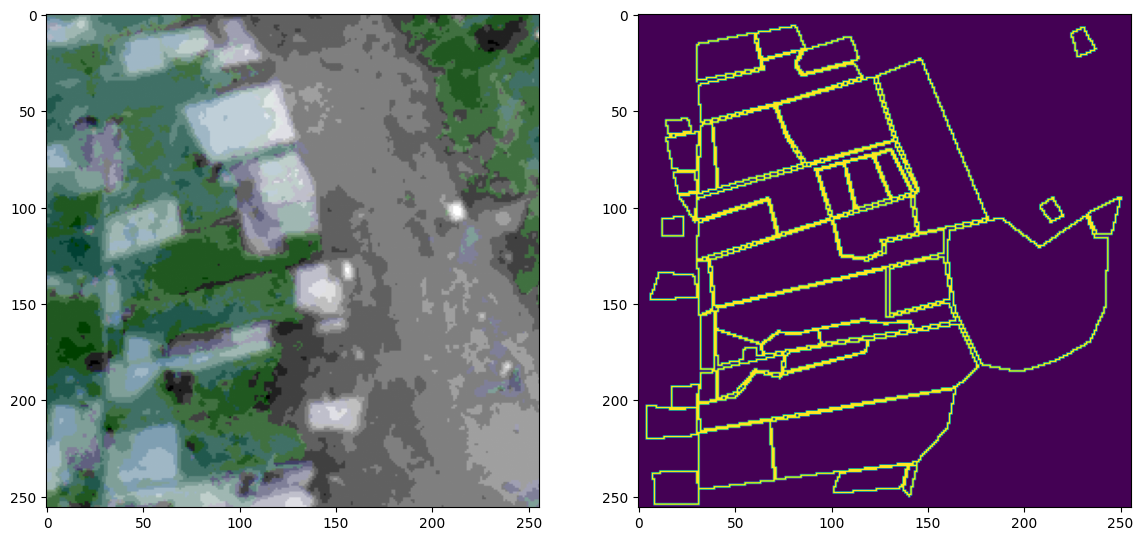

In [6]:
plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(train_data_subsets[2][50])
plt.subplot(122)
plt.imshow(label_image_dataset[50])

# **Test Train Set Preparation**

In [7]:
#train array shape
print("Shape of Train dataset/X_train : {}".format(np.array(train_image_dataset).shape))
#label array shape
print("Shape of Label dataset : {}".format(np.array(label_image_dataset).shape))
#number of unique class labels
print("Number of unique class labels : {}".format(len(np.unique(label_image_dataset))))
labels_categorical_dataset = to_categorical(label_image_dataset, num_classes = len(np.unique(label_image_dataset)))
labels_categorical_dataset = np.concatenate((labels_categorical_dataset,labels_categorical_dataset,labels_categorical_dataset,labels_categorical_dataset,labels_categorical_dataset,labels_categorical_dataset),axis = 0)
print("Shape of Categorical label Dataset/Y_train : {}".format(labels_categorical_dataset.shape))
print("Shape of test dataset/X_test : {}".format(np.array(test_image_dataset).shape))

Shape of Train dataset/X_train : (306, 256, 256, 4)
Shape of Label dataset : (51, 256, 256)
Number of unique class labels : 2
Shape of Categorical label Dataset/Y_train : (306, 256, 256, 2)
Shape of test dataset/X_test : (18, 256, 256, 4)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(train_image_dataset, labels_categorical_dataset, test_size=0.10, random_state=100)
print("X_train shape : {}".format(np.array(X_train).shape))
print("X_test shape : {}".format(np.array(X_test).shape))
print("Y_train shape : {}".format(np.array(y_train).shape))
print("Y_test shape : {}".format(np.array(y_test).shape))

X_train shape : (275, 256, 256, 4)
X_test shape : (31, 256, 256, 4)
Y_train shape : (275, 256, 256, 2)
Y_test shape : (31, 256, 256, 2)


In [9]:
X_train = train_image_dataset
y_train = labels_categorical_dataset

In [10]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(y_train)
Y_test = np.array(y_test)

In [11]:
X_test.shape

(31, 256, 256, 4)

# **MODEL training and prediction**

In [13]:
#save the model 
#model.save('BoundaryDetectionModel.h5')

In [14]:
# Define a sample CNN model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 4)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),  # Output 2 values for each pixel
    Dense(256 * 256 * 2, activation='softmax')  # Output 2 classes for each pixel
])

# Reshape the output to match the target shape
model.add(tf.keras.layers.Reshape((256, 256, 2)))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Compute the total number of parameters (model size)
total_params = model.count_params()
print(f"Total number of parameters (model size): {total_params}")

# Train the model (assuming you have X_train, Y_train, X_test, and Y_test defined)
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=5, batch_size=32)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, Y_test)

# Predict the test data
Y_pred = model.predict(X_test)

# Convert one-hot encoded predictions and ground truth back to binary masks
Y_pred_binary = np.argmax(Y_pred, axis=-1)
Y_test_binary = np.argmax(Y_test, axis=-1)

# Calculate the F1 score
f1 = f1_score(Y_test_binary.flatten(), Y_pred_binary.flatten(), average='weighted')

print(f'Test accuracy: {test_accuracy * 100:.2f}%')
print(f'Weighted F1 Score: {f1:.2f}')

#save the model 
model.save('BoundaryDetectionModel.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      592       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 123008)            0         
                                                                 
 dense (Dense)               (None, 32)                3

In [15]:
#create test folder
test_path = os.path.join('/kaggle/working/','test')
os.makedirs(test_path,exist_ok = True)

#get image id names
image_id_names = sorted(os.listdir('/kaggle/input/spacenus-bands-combined-images-and-labels/spacenus_combined_images_and_labels/test/2021_03'))

# **Save Images To Specific Directory**

In [17]:
test_dirs = os.listdir('/kaggle/input/spacenus-bands-combined-images-and-labels/spacenus_combined_images_and_labels/test')

for sub_data,dir_name in zip(test_data_subsets,test_dirs):
    
    path = os.path.join(test_path,dir_name)
    os.makedirs(path,exist_ok = True)
    
    image_set = model.predict(sub_data)

    for i,j in zip(range(len(image_set)),image_id_names):

        # Assuming 'image' is your (256, 256, 2) image
        # Calculate the average of the two channels
        grayscale_image = np.mean(image_set[i], axis=2)

        # Resize the grayscale image to 256x256 using interpolation
        
        resized_image = cv2.resize(grayscale_image, (256, 256))
        dir_path = os.path.join(path,j[:-4])
        os.makedirs(dir_path, exist_ok = True)
        file_name = "{}".format(j)
        file_path = os.path.join(dir_path,file_name)
        cv2.imwrite(file_path, resized_image)

1/1 [==============================] - 0s 83ms/step
